<a href="https://colab.research.google.com/github/Elman295/Crowd_Counting_Density_Estimation/blob/main/Crowd_counting_density_estimation_TransUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [28]:


import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import zipfile
from PIL import Image
import cv2

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
import torchmetrics

#`Data`

In [2]:
data_path = os.path.join("drive", "MyDrive","DATA","ShanghaiTech_Crowd_Counting_Dataset.zip")

with zipfile.ZipFile(data_path, "r") as f:
  f.extractall("data")

In [3]:

train_A_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_A_final", "train_data")
test_A_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_A_final", "test_data")

train_B_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_B_final", "train_data")
test_B_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_B_final", "test_data")

In [4]:
image_train_A = os.path.join(train_A_path, "images")
gt_train_A = os.path.join(train_A_path, "ground_truth")

image_test_A = os.path.join(test_A_path, "images")
gt_test_A = os.path.join(test_A_path, "ground_truth")

image_train_B = os.path.join(train_B_path, "images")
gt_train_B = os.path.join(train_B_path, "ground_truth")

image_test_B = os.path.join(test_B_path, "images")
gt_test_B = os.path.join(test_B_path, "ground_truth")

(654, 1024, 3)


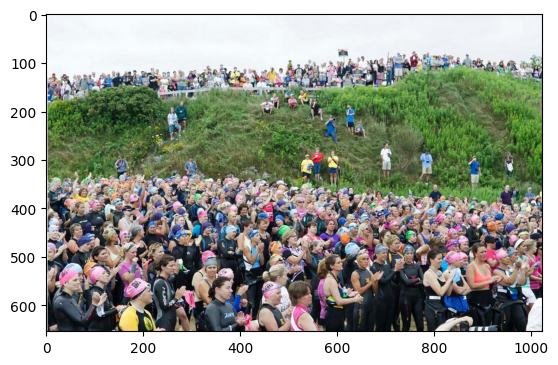

In [5]:
image_1 = Image.open(os.path.join(image_train_A, "IMG_100.jpg")).convert("RGB")
print(np.array(image_1).shape)
plt.imshow(image_1)
plt.show()

In [6]:
mat_1 = scipy.io.loadmat(os.path.join(gt_train_A,"GT_IMG_100.mat"))


In [7]:
def split(data):
  x = []
  y = []

  for i in range(len(data)):
    x.append(data[i][0])
    y.append(data[i][1])

  return x,y

In [8]:

def list_2_int(data):
  l = []
  for i in data:
    l.append(int(i))

  return l

In [9]:
def create_image(x,y, image):
  image = np.array(image)
  bg = np.zeros(shape = (image.shape[0], image.shape[1]))
  # bg[:] = [0,0,0]
  for i,j in zip(x,y):

      cv2.circle(bg,(i,j),15, color = (255,255,255), thickness = -1)



  return bg



In [10]:
class Density_count(Dataset):

  def __init__(self, images_path, annotated_path, transform = None):

    self.images_path = images_path
    self.annotated_path = annotated_path
    self.tfms = transform

  def __len__(self):
    return len(os.listdir(self.images_path))

  def __getitem__(self, idx):
    image_path = os.path.join(self.images_path, f"IMG_{idx+1}.jpg")
    image = Image.open(image_path).convert("RGB")

    annotated_file = scipy.io.loadmat(os.path.join(self.annotated_path,f"GT_IMG_{idx+1}.mat"))
    count = annotated_file["image_info"][0,0][0,0][0].shape[0]
    x,y = split(annotated_file["image_info"][0,0][0,0][0])
    x,y = list_2_int(x), list_2_int(y)
    segment = create_image(x,y,image)
    count = torch.tensor(count, dtype = torch.float32)
    segment = segment / 255
    segment = Image.fromarray(np.uint8((segment)*255))


    if self.tfms is not None:
      image = self.tfms(image)
      segment = self.tfms(segment)


    return image, count, segment.view(224,224).long()

In [11]:


tfms = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [12]:


train_ds = Density_count(image_train_A, gt_train_A, tfms)
test_ds = Density_count(image_test_A, gt_test_A, tfms)

In [13]:
train_dl = DataLoader(dataset = train_ds, batch_size = 32, shuffle = True)

test_dl = DataLoader(dataset = test_ds, batch_size = 32, shuffle = False)

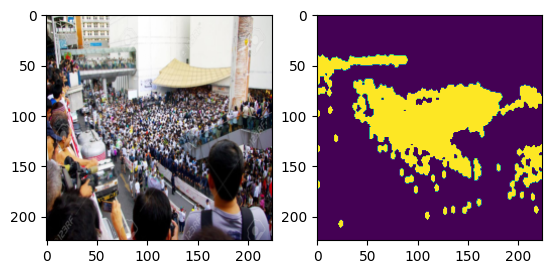

count: 975.0
torch.float32
tensor(1)


In [14]:
image, count,segment = train_ds[252]
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(segment)
plt.show()
print(f"count: {count}")
print(image.dtype)
print(segment.max())

In [15]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

#`TransUnet`

In [16]:
class TransUnet(nn.Module):

  def __init__(self, output_classes):
    super(TransUnet, self).__init__()

    ####  Encoder Conv

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(3,16,3,1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16,16,3,1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )

    self.mp_block_1 = nn.MaxPool2d(2,2, return_indices=True)

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(16,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )

    self.mp_block_2 = nn.MaxPool2d(2,2,return_indices=True)

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(32,64,3,1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,3,1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.mp_block_3 = nn.MaxPool2d(2,2, return_indices=True)

    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(64,128,3,1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,3,1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.mp_block_4 = nn.MaxPool2d(2,2,return_indices=True)

    ########################################

    #### Encoder Transformer

    self.encoder_layer = nn.TransformerEncoderLayer(100,10,dim_feedforward=1024)
    self.encoder = nn.TransformerEncoder( self.encoder_layer, num_layers=5)
    ###################################################################

    ### Decoder Deconv

    self.mpu_block_4 = nn.MaxUnpool2d(2,2)
    self.conv_4 = nn.Sequential(
        nn.Conv2d(256,128,3,1,padding=1),
        nn.ReLU()
    )
    self.deconv_4_block = nn.Sequential(
        nn.ConvTranspose2d(128,64,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(64,64,3,1),
        nn.ReLU()
    )

    self.mpu_block_3 = nn.MaxUnpool2d(2,2)

    self.conv_3 = nn.Sequential(
        nn.Conv2d(128,64,3,1,padding = 1),
        nn.ReLU()
    )

    self.deconv_3_block = nn.Sequential(
        nn.ConvTranspose2d(64,32,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(32,32,3,1),
        nn.ReLU()

    )

    self.mpu_block_2 = nn.MaxUnpool2d(2,2)

    self.conv_2 = nn.Sequential(
        nn.Conv2d(64,32,3,1,padding = 1),
        nn.ReLU()
    )

    self.deconv_2_block = nn.Sequential(
        nn.ConvTranspose2d(32,16,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(16,16,3,1),
        nn.ReLU()
    )

    self.mpu_block_1 = nn.MaxUnpool2d(2,2)

    self.conv_1 = nn.Sequential(
        nn.Conv2d(32,16,3,1, padding=1),
        nn.ReLU()
    )

    self.deconv_1_block = nn.Sequential(
        nn.ConvTranspose2d(16,8,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(8,6,3,1),
        nn.ReLU()
    )

    self.conv_final = nn.Conv2d(6,output_classes,1,1)



  def forward(self, x):

    x1 = self.conv_block_1(x)
    f1,i1 = self.mp_block_1(x1)
    x2 = self.conv_block_2(f1)
    f2,i2 = self.mp_block_2(x2)
    x3 = self.conv_block_3(f2)
    f3,i3 = self.mp_block_3(x3)
    x4 = self.conv_block_4(f3)
    f4, i4 = self.mp_block_4(x4)

    f4 = f4.view((-1,128,10*10))
    f5 = self.encoder(f4)
    f5 = f5.view((-1,128,10,10))

    f6 = self.mpu_block_4(f5, i4)
    f7 = self.conv_4(torch.cat((x4, f6), dim = 1))
    f8 = self.deconv_4_block(f7)

    f9 = self.mpu_block_3(f8, i3, output_size = x3.size())
    f10 = self.conv_3(torch.cat((f9,x3),dim =1 ))
    f11 = self.deconv_3_block(f10)

    f12 = self.mpu_block_2(f11, i2)
    f13 = self.conv_2(torch.cat((f12,x2), dim = 1))

    f14 = self.deconv_2_block(f13)

    f15 = self.mpu_block_1(f14, i1)
    f16 = self.conv_1(torch.cat((f15,x1), dim = 1))
    f17 = self.deconv_1_block(f16)
    f18 = self.conv_final(f17)

    return f18





In [21]:
model = TransUnet(2).to(device)
x = torch.rand(size = (16,3,224,224)).to(device)
y = model(x)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([16, 2, 224, 224])


In [22]:
loss_fn = nn.CrossEntropyLoss()


In [23]:
opt = torch.optim.Adam(params =model.parameters(), lr = 1e-3)


In [25]:
def train(data, model, loss_fn, opt):
  model.train()
  size = len(data.dataset)

  for b, (image, count, segment) in enumerate(data):

    image, segment = image.to(device), segment.to(device)
    mask_pred = model(image)
    opt.zero_grad()
    loss = loss_fn(mask_pred, segment)
    loss.backward()
    opt.step()

    if b% 100 == 0:
      print(f"loss:{loss.item()} [{b*len(image)} | {size}]")


In [26]:

for e in range(50):
  print(f"epoch:{e+1}=-=-=-=-")
  train(train_dl, model, loss_fn, opt)

epoch:1=-=-=-=-
loss:0.7421660423278809 [0 | 300]
epoch:2=-=-=-=-
loss:0.5740522146224976 [0 | 300]
epoch:3=-=-=-=-
loss:0.5707733631134033 [0 | 300]
epoch:4=-=-=-=-
loss:0.48617100715637207 [0 | 300]
epoch:5=-=-=-=-
loss:0.4902659058570862 [0 | 300]
epoch:6=-=-=-=-
loss:0.4910849630832672 [0 | 300]
epoch:7=-=-=-=-
loss:0.4696386754512787 [0 | 300]
epoch:8=-=-=-=-
loss:0.4929957389831543 [0 | 300]
epoch:9=-=-=-=-
loss:0.4718812108039856 [0 | 300]
epoch:10=-=-=-=-
loss:0.48163601756095886 [0 | 300]
epoch:11=-=-=-=-
loss:0.45956090092658997 [0 | 300]
epoch:12=-=-=-=-
loss:0.490169882774353 [0 | 300]
epoch:13=-=-=-=-
loss:0.45768964290618896 [0 | 300]
epoch:14=-=-=-=-
loss:0.45995378494262695 [0 | 300]
epoch:15=-=-=-=-
loss:0.46007484197616577 [0 | 300]
epoch:16=-=-=-=-
loss:0.5439363121986389 [0 | 300]
epoch:17=-=-=-=-
loss:0.49302852153778076 [0 | 300]
epoch:18=-=-=-=-
loss:0.4414834678173065 [0 | 300]
epoch:19=-=-=-=-
loss:0.4348032772541046 [0 | 300]
epoch:20=-=-=-=-
loss:0.4146766960

In [29]:
jaccard = torchmetrics.JaccardIndex(task = "multiclass", num_classes=2).to(device)

accuracy: 0.6550071239471436


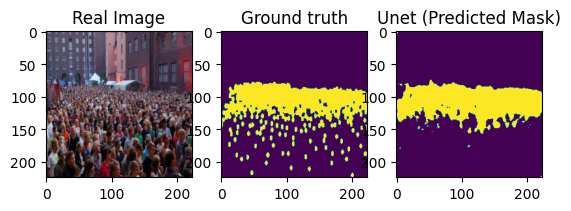

In [34]:
image, count, seg = next(iter(train_dl))
image = image.to(device)
seg = seg.to(device)
mask_pred = model(image)

print(f"accuracy: {jaccard(mask_pred,seg)}")

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[0].cpu().permute(1,2,0))
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(seg[0].cpu().numpy())
plt.subplot(1,3,3)
plt.title("Unet (Predicted Mask)")
plt.imshow(mask_pred[0].cpu().detach().numpy().argmax(0))

plt.show()

accuracy: 0.6230927109718323


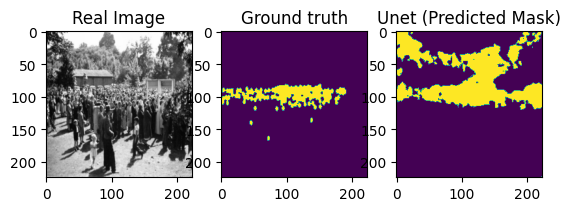

In [36]:
image, count, seg = next(iter(test_dl))
image = image.to(device)
seg = seg.to(device)
mask_pred = model(image)

print(f"accuracy: {jaccard(mask_pred,seg)}")

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[0].cpu().permute(1,2,0))
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(seg[0].cpu().numpy())
plt.subplot(1,3,3)
plt.title("Unet (Predicted Mask)")
plt.imshow(mask_pred[0].cpu().detach().numpy().argmax(0))

plt.show()